In [1]:
import importlib
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# 各資産の年率期待リターン
mu_assets = {
    "asset0": 1.43*1e-02,
    "asset1": 5.19*1e-02,
    "asset2": 3.46*1e-02,
    "asset3": 0.86*1e-02,
    "asset4": 5.95*1e-02,
    "asset5": 2.67*1e-02,
    "asset6": 5.84*1e-02,
    "asset7": 7.28*1e-02,
    "asset8": 0,
}
# 各資産の年率期待リスク
sig_assets = {
    "asset0": np.sqrt(2.36*1e-02),
    "asset1": np.sqrt(14.60*1e-02),
    "asset2": np.sqrt(7.48*1e-02),
    "asset3": np.sqrt(4.75*1e-02),
    "asset4": np.sqrt(17.13*1e-02),
    "asset5": np.sqrt(14.45*1e-02),
    "asset6": np.sqrt(14.46*1e-02),
    "asset7": np.sqrt(18.99*1e-02),
    "asset8": 0,
}

Sig = np.array([
    [0.056*1e-02, -0.034*1e-02, 0.012*1e-02, 0.056*1e-02, 0.002*1e-02, 0.053*1e-02, 0.065*1e-02, 0.073*1e-02, 0.000*1e-02],
    [-0.034*1e-02, 2.130*1e-02, 0.520*1e-02, -0.100*1e-02, 1.939*1e-02, 1.332*1e-02, 0.970*1e-02, 1.584*1e-02, 0.000*1e-02],
    [0.012*1e-02, 0.520*1e-02, 0.560*1e-02, -0.014*1e-02, 0.786*1e-02, 0.223*1e-02, 0.207*1e-02, 0.674*1e-02, 0.000*1e-02],
    [0.056*1e-02, -0.100*1e-02, -0.014*1e-02, 0.226*1e-02, -0.132*1e-02, 0.166*1e-02, 0.012*1e-02, 0.086*1e-02, 0.000*1e-02],
    [0.002*1e-02, 1.939*1e-02, 0.786*1e-02, -0.132*1e-02, 2.935*1e-02, 1.919*1e-02, 1.104*1e-02, 2.576*1e-02, 0.000*1e-02],
    [0.053*1e-02, 1.332*1e-02, 0.223*1e-02, 0.166*1e-02, 1.919*1e-02, 2.087*1e-02, 0.909*1e-02, 2.002*1e-02, 0.000*1e-02],
    [0.065*1e-02, 0.970*1e-02, 0.207*1e-02, 0.012*1e-02, 1.104*1e-02, 0.909*1e-02, 2.090*1e-02, 1.389*1e-02, 0.000*1e-02],
    [0.073*1e-02, 1.584*1e-02, 0.674*1e-02, 0.086*1e-02, 2.576*1e-02, 2.002*1e-02, 1.389*1e-02, 3.606*1e-02, 0.000*1e-02],
    [0.000*1e-02, 0.000*1e-02, 0.000*1e-02, 0.000*1e-02, 0.000*1e-02, 0.000*1e-02, 0.000*1e-02, 0.000*1e-02, 0.000*1e-02],
])

# 各リスク許容度RTごとのポートフォリオのボラティリティと期待リターンとアロケーション
weights = pd.DataFrame()
weights["RT"] = np.arange(0, 10, 1)
weights["Vol"] = [0, 0.0243, 0.0326, 0.0431, 0.0586, 0.0735, 0.0891, 0.1076, 0.1199, 0.1291]
weights["E[r]"] = [0.0001, 0.0165, 0.0214, 0.0274, 0.0335, 0.039, 0.0439, 0.0491, 0.053, 0.0556]
weights["asset0"] = [0, 0.2, 0.26, 0.3, 0.23, 0.18, 0.13, 0.07, 0.03, 0]
weights["asset1"] = [0, 0.06, 0.09, 0.1, 0.13, 0.16, 0.18, 0.21, 0.23, 0.24]
weights["asset2"] = [0, 0.14, 0.18, 0.23, 0.22, 0.2, 0.19, 0.16, 0.15, 0.11]
weights["asset3"] = [0, 0.16, 0.2, 0.24, 0.19, 0.14, 0.09, 0.04, 0, 0]
weights["asset4"] = [0, 0.02, 0.02, 0.03, 0.08, 0.12, 0.17, 0.22, 0.25, 0.29]
weights["asset5"] = [0, 0, 0, 0, 0, 0, 0.01, 0.04, 0.05, 0.05]
weights["asset6"] = [0, 0.04, 0.06, 0.08, 0.1, 0.12, 0.12, 0.12, 0.13, 0.13]
weights["asset7"] = [0, 0, 0, 0.02, 0.05, 0.08, 0.11, 0.14, 0.16, 0.18]
weights["asset8"] = [1, 0.38, 0.19, 0, 0, 0, 0, 0, 0, 0]

# ---- Simulation helpers ----
def annual_to_period_params(mu_a: float, sig_a: float, periods_per_year: int, model: str = "gaussian"):
    P = periods_per_year
    if model == "gaussian":
        mu_p = mu_a / P
        sig_p = sig_a / np.sqrt(P)
        return mu_p, sig_p
    elif model == "gbm":
        mu_log_p = np.log(1.0 + mu_a) / P
        sig_log_p = sig_a / np.sqrt(P)
        return mu_log_p, sig_log_p
    else:
        raise ValueError("model must be 'gaussian' or 'gbm'")

def simulate_returns(mu_dict, sig_dict, n_periods=120, freq="M", model="gaussian", corr=None, seed=42):
    rng = np.random.default_rng(seed)
    assets = list(mu_dict.keys())
    n = len(assets)
    if freq == "M":
        P = 12
    elif freq == "W":
        P = 52
    elif freq == "D":
        P = 252
    else:
        raise ValueError("freq must be one of 'M', 'W', 'D'")

    if corr is None:
        R = np.eye(n)
    else:
        R = corr.reindex(index=assets, columns=assets).to_numpy()

    if model == "gaussian":
        mu_p = np.array([annual_to_period_params(mu_dict[a], sig_dict[a], P, "gaussian")[0] for a in assets])
        sig_p = np.array([annual_to_period_params(mu_dict[a], sig_dict[a], P, "gaussian")[1] for a in assets])
        D = np.diag(sig_p)
        cov = D @ R @ D
        shocks = rng.multivariate_normal(mean=np.zeros(n), cov=cov, size=n_periods)
        rets = shocks + mu_p
    else:
        mu_log_p = np.array([annual_to_period_params(mu_dict[a], sig_dict[a], P, "gbm")[0] for a in assets])
        sig_log_p = np.array([annual_to_period_params(mu_dict[a], sig_dict[a], P, "gbm")[1] for a in assets])
        D = np.diag(sig_log_p)
        cov_log = D @ R @ D
        eps = rng.multivariate_normal(mean=np.zeros(n), cov=cov_log, size=n_periods)
        rets = np.exp(mu_log_p + eps) - 1.0

    idx = pd.date_range(start="2005-01-31", periods=n_periods, freq=freq)
    df = pd.DataFrame(rets, index=idx, columns=assets)
    return df

# ---- Run a default simulation (monthly, 10 years = 120 periods) ----
df_returns = simulate_returns(mu_assets, sig_assets, n_periods=120, freq="M", model="gaussian", corr=None, seed=123)

# ブートストラップ法でリサンプリング
def bootstrap(rets, n_steps):
    return rets.sample(n_steps, replace=True).values

In [3]:
INIT_VAL = 100
WITHDRAWAL_RATE = 0.03 / 12 # per month
RT = 9
N_STEPS = 12 * 35 # month
N_PATHS = 10
AGE = np.arange(65, 100+1/12, 1/12)

return_opt = np.array([bootstrap(df_returns, n_steps=N_STEPS) for _ in range(N_PATHS)])
return_control = np.array([bootstrap(df_returns, n_steps=N_STEPS) for _ in range(N_PATHS)])
weight_candiate = weights.iloc[:RT, 3:].values

In [4]:
asset_cols = weights.columns[3:]
asset_cols

Index(['asset0', 'asset1', 'asset2', 'asset3', 'asset4', 'asset5', 'asset6',
       'asset7', 'asset8'],
      dtype='object')

In [5]:
def g_fin_data(init_amount, maturity, div_rate, discount_rate):
    benefit_cf = [0, *[div_rate*init_amount for i in range(maturity)]]
    benefit_pv = []
    for t in range(1, maturity+1):
        dcf = [d/((1+discount_rate)**i)
               for i,d in enumerate(benefit_cf[t:])]
        benefit_pv_t = sum(dcf)
        benefit_pv.append(benefit_pv_t)
    benefit_pv.append(0)
    contribution = [0 for _ in range(maturity+1)]
    return [benefit_cf, benefit_pv, contribution]

fin_data = g_fin_data(INIT_VAL, N_STEPS, WITHDRAWAL_RATE, 0)

In [6]:
def cal_mu_for_given_weight(weight, asset_mu):
    return np.dot(weight, asset_mu)

def cal_portfolio_value(weights, eval_date, data, fin_data, realized_asset_value):
    oldreturn_opt = np.dot(data, weights)
    return_opt = oldreturn_opt[:, eval_date:]
    portfolio = np.zeros((return_opt.shape[0], return_opt.shape[1] + 1))
    portfolio[:, 0] = realized_asset_value
    for i in range(1, portfolio.shape[1]):
        fin_index = eval_date + i
        portfolio[:, i] = portfolio[:, i - 1] * (1 + return_opt[:, i - 1]) - fin_data[0][fin_index]
    return portfolio

def cal_prob_with_shortage(portfolio, fin_data, eval_date, is_all_period_prob, objective_func):
    count = 0
    """
    for i in range(portfolio.shape[1]):
        fin_index = eval_date + i
        portfolio[:, i] += fin_data[2][fin_index] - fin_data[1][fin_index]
    """
    if is_all_period_prob == True:
        for i in range(portfolio.shape[0]):
            if np.min(portfolio[i, :]) >= 0:
                count += 1
    else:
        for i in range(portfolio.shape[0]):
            if portfolio[i, -1] >= 0:
                count += 1

    shortage = - portfolio[portfolio < 0.0].sum() / portfolio.shape[0]
    return count / portfolio.shape[0], shortage

def cal_target_prob_with_shortage(weights, eval_date, data, fin_data, realized_asset_value, is_all_period_prob, objective_func):
    portfolio = cal_portfolio_value(
        weights, 
        eval_date, 
        data, 
        fin_data, 
        realized_asset_value
    )
    return cal_prob_with_shortage(portfolio, fin_data, eval_date, is_all_period_prob, objective_func)

In [7]:
CONVERGENCE_WEIGHT = weights.loc[3][3:].values #[0.7, 0.1, 0.1, 0.1]

In [8]:
def optimize_shortage(
    eval_date, 
    data, 
    fin_data, 
    weights, 
    min_prob,
    realized_asset_value, 
    is_all_period_prob=True,
    init_prob=None, 
    objective_type=None,
    objective_func=None, 
    restriction=None
    ):
    
    def prob_const(x, eval=eval_date, dat=data, fdat=fin_data, asset_val=realized_asset_value,
                   isAll=is_all_period_prob, objFunc=objective_func):
        return cal_target_prob_with_shortage(x, eval, dat, fdat, asset_val, isAll, objFunc)
    
    result = [np.array([0 for i in range(data.shape[2])]), 0, 0, -1, -1]
    minimum_shortage = float("inf")
    maximum_prob = -float("inf")

    if not realized_asset_value > 0:
        result = [np.array([0 for i in range(data.shape[2])]), 0, realized_asset_value * ((1 + 0) ** (N_STEPS - eval_date)), -1, -1]
        return result
    
    if restriction == "const":
        required_return = 0.02
    elif restriction == "dynamic":
        required_return = min(0.02 * fin_data[1][eval_date] / realized_asset_value, 0.03)
    else:
        required_return = 0.00
    if objective_type == "shortage":
        for rt, x in enumerate(weights):
            prob, shortage = prob_const(x)
            if 1 - prob < 0.00001:
                return [np.array(CONVERGENCE_WEIGHT), 1, 0, 0, int(rt+1)]
            if shortage < minimum_shortage:
                result = [np.copy(x), prob, shortage, 0, int(rt+1)]
                minimum_shortage = shortage
    else:
        raise TypeError("Choose implemented objective function name")
    
    return result

In [9]:
eval_date = 0
is_all_period_prob = True

OBJECTIVE_TYPE_SET = ("prob", "shortage", "const")
OBJECTIVE_TYPE = OBJECTIVE_TYPE_SET[1]
objective_type = "shortage" # OBJECTIVE_TYPE

LOWER_OBJECTIVE_SET = ("mean_shortage",)
LOWER_OBJECTIVE = LOWER_OBJECTIVE_SET[0]
objective_func = "mean_shortage" # LOWER_OBJECTIVE

RETURN_RESTRICTION_SET = ("const", "dynamic", "unrestricted")
RETURN_RESTRICTION = RETURN_RESTRICTION_SET[2]
restriction = "unrestricted" # RETURN_RESTRICTION

init_value = INIT_VAL
initi_node = optimize_shortage(
    eval_date,
    return_opt,
    fin_data,
    weight_candiate,
    0,
    init_value,
    is_all_period_prob,
    None,
    objective_type,
    objective_func,
    restriction
)
init_prob = initi_node[1]

In [10]:
initi_node

[array([0.3 , 0.1 , 0.23, 0.24, 0.03, 0.  , 0.08, 0.02, 0.  ]), 1, 0, 0, 5]

In [11]:
def multi_proc(params):
    path = []
    term = N_STEPS

    i = params[0]
    initi_node = params[1]
    return_opt = params[2]
    return_control = params[3]
    fin_data = params[4]
    weight_candiate = params[5]
    prob_const = params[6]
    is_all_period_prob = params[7]
    init_value = params[8]
    init_prob = params[9]
    objective_type = params[10]
    objective_func = params[11]
    restriction = params[12]

    path_return = np.dot(initi_node[0], return_control[i][0])
    realized_asset_value = init_value * (1 + path_return) - fin_data[0][1]

    path.append([initi_node, init_value])

    for j in range(1, term):
        eval_path_date = j
        res = optimize_shortage(eval_path_date, return_opt, fin_data, weight_candiate, prob_const,
                                realized_asset_value, is_all_period_prob, init_prob, objective_type, objective_func,
                                restriction)
        
        path_return = np.dot(res[0], return_control[i][j])
        path.append([res, realized_asset_value])
        if realized_asset_value <= 0:
            realized_asset_value = realized_asset_value - fin_data[0][j + 1]
        else:
            realized_asset_value = realized_asset_value * (1 + path_return) - fin_data[0][j + 1]
    
        if j == (term - 1):
            if realized_asset_value >= 0:
                path.append([[res[0], 1, 0, 0, res[-1]], realized_asset_value])
            else:
                path.append([[res[0], 0, realized_asset_value, -1, res[-1]], realized_asset_value])
    return path 

In [12]:
params = []
for i in range(N_PATHS):
    params.append([
        i,
        initi_node.copy(),
        return_opt.copy(),
        return_control.copy(),
        fin_data.copy(),
        weight_candiate.copy(),
        0,
        is_all_period_prob,
        init_value,
        init_prob,
        objective_type,
        objective_func,
        restriction
    ])

In [13]:
all_paths = []
for param in params:
    result = multi_proc(param)
    all_paths.append(result)

In [14]:
np.array(all_paths, dtype=object).shape

(10, 421, 2)

In [15]:
import pickle
filename = "test.pkl"
with open(filename, "wb") as f:
    pickle.dump(all_paths, f)

In [16]:
with open(filename, "rb") as f:
    res = pickle.load(f)

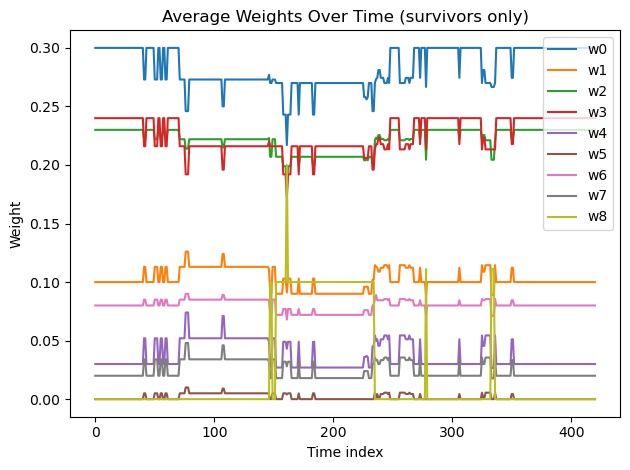

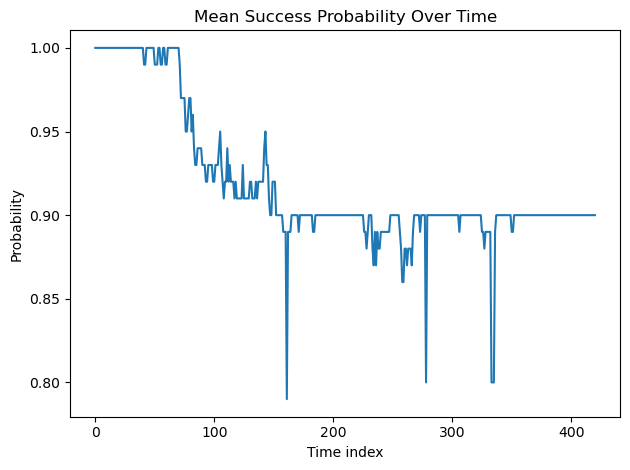

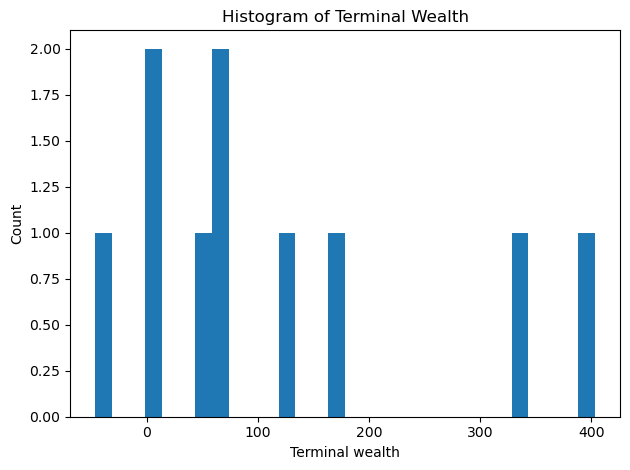

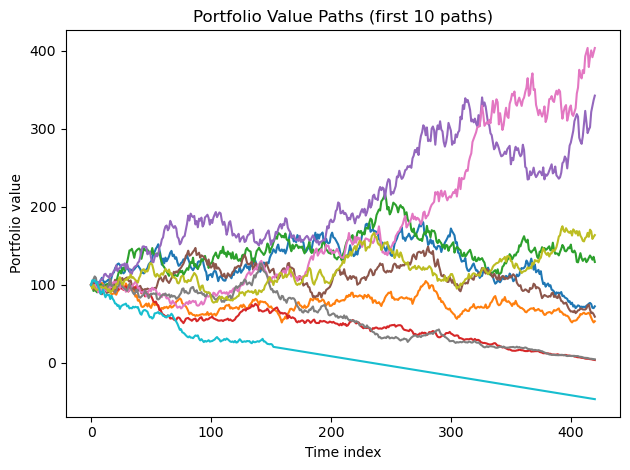

Data source for `res`: from-session
N_paths: 10 | T_max: 421 | W: 9
Surviving counts by time (for avg weights): [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

In [ ]:
# Re-run the plotting cell. The previous attempt did not execute due to a transient issue.
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

def _load_res_if_needed():
    if 'res' in globals():
        return globals()['res'], 'from-session'
    for p in ['/mnt/data/res.npy', '/mnt/data/res.pkl']:
        if os.path.exists(p):
            try:
                if p.endswith('.npy'):
                    arr = np.load(p, allow_pickle=True)
                    return arr.tolist(), p
                else:
                    with open(p, 'rb') as f:
                        obj = pickle.load(f)
                    return obj, p
            except Exception:
                pass
    # mock
    rng = np.random.default_rng(0)
    W = 3; T = 8; N = 10
    mock_res = []
    for _ in range(N):
        path = []
        val = 1000.0
        for t in range(T):
            w = rng.random(W); w = w / w.sum()
            r = rng.normal(0.004, 0.02)
            val = val * (1 + r) - (10.0 if t >= 1 else 0.0)
            prob = 1.0; shortage = 0.0; state = 0
            path.append(([w, prob, shortage, state], float(val)))
        mock_res.append(path)
    return mock_res, 'mock'

res, res_source = _load_res_if_needed()

def _infer_dims(res):
    W = None; T_max = 0
    for p in res:
        T_max = max(T_max, len(p))
        for (meta, val) in p:
            w = np.asarray(meta[0])
            if w.ndim == 1:
                W = w.shape[0]; break
        if W is not None:
            break
    if W is None:
        raise ValueError("Could not infer W from res.")
    return W, T_max

W, T_max = _infer_dims(res)
N_paths = len(res)

avg_weights = np.full((T_max, W), np.nan, dtype=float)
counts_by_t = np.zeros(T_max, dtype=int)
for t in range(T_max):
    sum_w = np.zeros(W, dtype=float); cnt = 0
    for p in res:
        if t < len(p):
            meta, val = p[t]
            w = np.asarray(meta[0], dtype=float)
            if np.isfinite(val) and val >= 0 and np.isfinite(w).all():
                sum_w += w; cnt += 1
    if cnt > 0:
        avg = sum_w / cnt
        s = avg.sum()
        if s > 0: avg = avg / s
        avg_weights[t] = avg
        counts_by_t[t] = cnt

prob_traj = np.full(T_max, np.nan, dtype=float)
for t in range(T_max):
    vals = []
    for p in res:
        if t < len(p):
            meta, _ = p[t]
            pr = meta[1]
            if pr is not None and np.isfinite(pr):
                vals.append(float(pr))
    if len(vals) > 0:
        prob_traj[t] = float(np.mean(vals))

expected_return_traj = None
if 'asset_mu_periodic' in globals():
    mu_vec = np.asarray(globals()['asset_mu_periodic'], dtype=float).reshape(-1)
    if mu_vec.shape[0] == W:
        expected_return_traj = np.full(T_max, np.nan, dtype=float)
        for t in range(T_max):
            vals = []
            for p in res:
                if t < len(p):
                    meta, val = p[t]
                    w = np.asarray(meta[0], dtype=float)
                    if np.isfinite(w).all():
                        vals.append(float(np.dot(w, mu_vec)))
            if len(vals) > 0:
                expected_return_traj[t] = float(np.mean(vals))

terminal_vals = []
for p in res:
    if len(p) > 0:
        terminal_vals.append(float(p[-1][1]))
terminal_vals = np.array(terminal_vals, dtype=float)

# 1) Average weight trajectories
plt.figure()
for j in range(W):
    plt.plot(avg_weights[:, j], label=f"w{j}")
plt.title("Average Weights Over Time (survivors only)")
plt.xlabel("Time index")
plt.ylabel("Weight")
plt.legend()
plt.tight_layout()
plt.show()

# 2) Probability trajectory
plt.figure()
plt.plot(prob_traj)
plt.title("Mean Success Probability Over Time")
plt.xlabel("Time index")
plt.ylabel("Probability")
plt.tight_layout()
plt.show()

# 3) Expected return trajectory (optional)
if expected_return_traj is not None:
    plt.figure()
    plt.plot(expected_return_traj)
    plt.title("Expected Return Trajectory (avg w_t · μ)")
    plt.xlabel("Time index")
    plt.ylabel("Expected Return (per period)")
    plt.tight_layout()
    plt.show()

# 4) Histogram of terminal wealth
plt.figure()
plt.hist(terminal_vals, bins=30)
plt.title("Histogram of Terminal Wealth")
plt.xlabel("Terminal wealth")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 5) Time-series of portfolio value paths (subset)
plt.figure()
max_lines = min(50, N_paths)
for idx in range(max_lines):
    series = [p_t[1] for p_t in res[idx]]
    plt.plot(series)
plt.title(f"Portfolio Value Paths (first {max_lines} paths)")
plt.xlabel("Time index")
plt.ylabel("Portfolio value")
plt.tight_layout()
plt.show()

# Save useful arrays
"""
np.save('/mnt/data/avg_weights.npy', avg_weights)
np.save('/mnt/data/prob_traj.npy', prob_traj)
if expected_return_traj is not None:
    np.save('/mnt/data/expected_return_traj.npy', expected_return_traj)
np.save('/mnt/data/terminal_vals.npy', terminal_vals)
"""
print("Data source for `res`:", res_source)
print("N_paths:", N_paths, "| T_max:", T_max, "| W:", W)
print("Surviving counts by time (for avg weights):", counts_by_t.tolist())


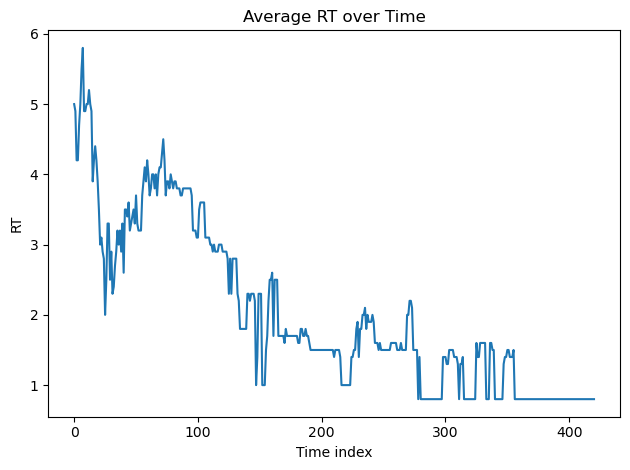

In [19]:
T_max = max(len(p) for p in res)
avg_rt = [np.mean([p[t][0][4] for p in res if t < len(p)]) for t in range(T_max)]

import matplotlib.pyplot as plt
plt.figure()
plt.plot(avg_rt)
plt.title("Average RT over Time")
plt.xlabel("Time index")
plt.ylabel("RT")
plt.tight_layout(); plt.show()

In [21]:
expected_return_traj

0    0.0001
1    0.0165
2    0.0214
3    0.0274
4    0.0335
5    0.0390
6    0.0439
7    0.0491
8    0.0530
9    0.0556
Name: E[r], dtype: float64